In [ ]:
from google.colab import drive
drive.mount('/gdrive')

Drive already mounted at /gdrive; to attempt to forcibly remount, call drive.mount("/gdrive", force_remount=True).


In [ ]:
# Change to my working directory
!cd /gdrive/MyDrive

In [ ]:
import os
import cv2
import keras
import numpy as np
from glob import glob
import tensorflow as tf
import matplotlib.pyplot as plt

from tensorflow.keras import layers
from tensorflow.keras.layers import Input, Conv2D, Conv2DTranspose, concatenate, BatchNormalization, Activation, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.metrics import Recall, Precision
from tensorflow.keras import backend as K

AUTOTUNE = tf.data.experimental.AUTOTUNE
print(f"Tensorflow ver. {tf.__version__}")

Tensorflow ver. 2.4.1


In [ ]:
# Input image size that we are going to use
IMAGE_SIZE = 224
# ADE20k has 151 classes (background + 150 object) 
num_classes = 151
# Set batch size
batch = 2
# Set learning rate
LR = 1e-4
# Set epoch
EPOCHS = 5

In [ ]:
# Set image and mask paths
image_path = "/gdrive/MyDrive/ISS Cert Project/base_model/ADEChallengeData2016/images/"
mask_path = "/gdrive/MyDrive/ISS Cert Project/base_model/ADEChallengeData2016/annotations/"
training_data = "training/"
val_data = "validation/"

In [ ]:
# Function to create lists of paths for training, validation and testing data
def load_data():

  TRAIN_X = sorted(glob(os.path.join(image_path + training_data, "*.jpg")))
  train_x = TRAIN_X[:5000]

  TRAIN_Y = sorted(glob(os.path.join(mask_path + training_data, "*.png")))
  train_y = TRAIN_Y[:5000]

  VALID_TEST_X = sorted(glob(os.path.join(image_path + val_data, "*.jpg")))
  valid_x = VALID_TEST_X[:500]

  VALID_TEST_Y = sorted(glob(os.path.join(mask_path + val_data, "*.png")))
  valid_y = VALID_TEST_Y[:500]

  test_x = VALID_TEST_X[500:600]
  test_y = VALID_TEST_Y[500:600]

  return (train_x, train_y), (valid_x, valid_y), (test_x, test_y)

In [ ]:
(train_x, train_y), (valid_x, valid_y), (test_x, test_y) = load_data()

print("Training data: ", len(train_x))
print("Validation data: ", len(valid_x))
print("Test data: ", len(test_x))

Training data:  5000
Validation data:  500
Test data:  100


In [ ]:
# Set image augmentation (to be called by tensorflow dataset later)
data_augmentation = tf.keras.Sequential([
  layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
  layers.experimental.preprocessing.RandomRotation(0.2),
  layers.experimental.preprocessing.RandomZoom(.5, .2),
  layers.experimental.preprocessing.RandomContrast(0.1)],
  )

In [ ]:
# Functions to read image and mask paths to output numpy arrays
def read_image(path):
    path = path.decode()
    x = cv2.imread(path, cv2.IMREAD_COLOR)
    x = cv2.resize(x, (IMAGE_SIZE, IMAGE_SIZE))
    x = x/255.0
    return x

def read_mask(path):
    path = path.decode()
    x = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
    x = cv2.resize(x, (IMAGE_SIZE, IMAGE_SIZE))
    x = np.expand_dims(x, axis=-1)
    return x

In [ ]:
# Function to generate tensorflow dataset 
def tf_parse(x, y):
    def _parse(x, y):
        x = read_image(x)
        y = read_mask(y)
        return x, y

    x, y = tf.numpy_function(_parse, [x, y], [tf.float64, tf.uint8])
    x.set_shape([IMAGE_SIZE, IMAGE_SIZE, 3])
    y.set_shape([IMAGE_SIZE, IMAGE_SIZE, 1])
    return x, y

num_threads = 4

def tf_dataset_train(x, y, batch=batch):
    dataset = tf.data.Dataset.from_tensor_slices((x, y))
    dataset = dataset.shuffle(buffer_size=5000)
    dataset = dataset.repeat()
    dataset = dataset.map(tf_parse, num_parallel_calls=num_threads)
    dataset = dataset.batch(batch)
    #dataset = dataset.map(lambda x, y: (data_augmentation(x, training=True), y), num_parallel_calls=tf.data.AUTOTUNE)
    dataset = dataset.prefetch(1)
    return dataset


def tf_dataset_valid(x, y, batch=batch):
    dataset = tf.data.Dataset.from_tensor_slices((x, y))
    dataset = dataset.shuffle(buffer_size=500)
    dataset = dataset.repeat()
    dataset = dataset.map(tf_parse, num_parallel_calls=num_threads)
    dataset = dataset.batch(batch)
    dataset = dataset.prefetch(1)
    return dataset

In [ ]:
train_dataset = tf_dataset_train(train_x, train_y)
valid_dataset = tf_dataset_valid(valid_x, valid_y)
test_dataset = tf_dataset_valid(test_x, test_y)

In [ ]:
# Function to load image/mask and convert colour space from BGR to RGB so that image/mask can be displayed correctly by matplotlib
def read_and_rgb(x):
    x = cv2.imread(x)
    x = cv2.cvtColor(x, cv2.COLOR_BGR2RGB)
    return x

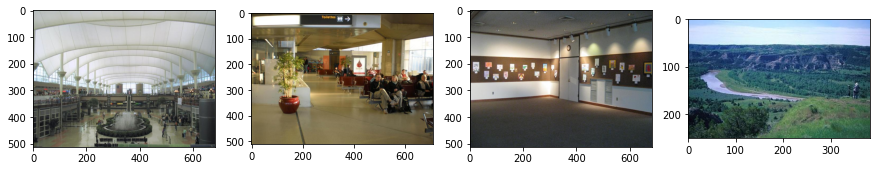

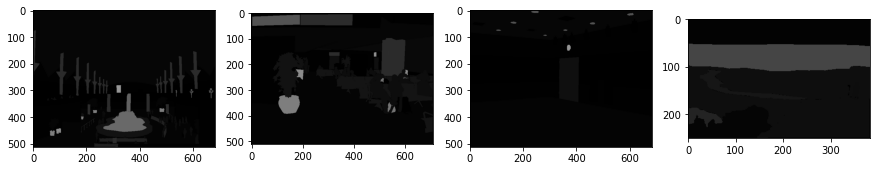

In [ ]:
# Plot samples of images and corresponding masks 
fig = plt.figure(figsize=(15, 15))
a = fig.add_subplot(1, 4, 1)
imgplot = plt.imshow(read_and_rgb(train_x[0]))

a = fig.add_subplot(1, 4, 2)
imgplot = plt.imshow(read_and_rgb(train_x[1]))
imgplot.set_clim(0.0, 0.7)

a = fig.add_subplot(1, 4, 3)
imgplot = plt.imshow(read_and_rgb(train_x[2]))
imgplot.set_clim(0.0, 1.4)

a = fig.add_subplot(1, 4, 4)
imgplot = plt.imshow(read_and_rgb(train_x[3]))
imgplot.set_clim(0.0, 2.1)

fig = plt.figure(figsize=(15, 15))
a = fig.add_subplot(1, 4, 1)
imgplot = plt.imshow(read_and_rgb(train_y[0]))

a = fig.add_subplot(1, 4, 2)
imgplot = plt.imshow(read_and_rgb(train_y[1]))
imgplot.set_clim(0.0, 0.7)

a = fig.add_subplot(1, 4, 3)
imgplot = plt.imshow(read_and_rgb(train_y[2]))
imgplot.set_clim(0.0, 1.4)

a = fig.add_subplot(1, 4, 4)
imgplot = plt.imshow(read_and_rgb(train_y[3]))
imgplot.set_clim(0.0, 1.4)

In [ ]:
# Function for conv2d_block (to be used for building decoder of unet)
def conv2d_block(input_tensor, n_filters, kernel_size = 3, batchnorm = True):
    x = Conv2D(filters = n_filters, kernel_size = (kernel_size, kernel_size), kernel_initializer = 'he_normal', padding = 'same')(input_tensor)
    if batchnorm:
        x = BatchNormalization()(x)
    x = Activation('relu')(x)
    return x

In [ ]:
# Function for unet model creation
def unet(n_filters = 16, batchnorm = True, dropout = 0.1, num_classes=151):

    # Contracting Path (encoder)
    inputs = Input(shape=(IMAGE_SIZE, IMAGE_SIZE, 3), name="input_image")
    encoder = MobileNetV2(input_tensor=inputs, include_top=False)

    BASE_WEIGHT_PATH = ('https://github.com/fchollet/deep-learning-models/releases/download/v0.6/')
    model_name = 'mobilenet_%s_%d_tf_no_top.h5' % ('1_0', 224)
    weight_path = BASE_WEIGHT_PATH + model_name
    weights_path = keras.utils.get_file(model_name, weight_path)
    encoder.load_weights(weights_path, by_name=True, skip_mismatch=True)

    skip_connection_names = ["input_image", "block_1_expand_relu", "block_3_expand_relu", "block_6_expand_relu"]
    encoder_output = encoder.get_layer("block_13_expand_relu").output

    x = encoder_output
    x_skip_1 = encoder.get_layer(skip_connection_names[-1]).output # 224x224
    x_skip_2 = encoder.get_layer(skip_connection_names[-2]).output # 112x112
    x_skip_3 = encoder.get_layer(skip_connection_names[-3]).output # 56x56
    x_skip_4 = encoder.get_layer(skip_connection_names[-4]).output # 28x28


    # Expansive Path (decoder)
    u6 = Conv2DTranspose(n_filters * 13, (3, 3), strides = (2, 2), padding = 'same')(x)
    u6 = concatenate([u6, x_skip_1])
    c6 = conv2d_block(u6, n_filters * 13, kernel_size = 3, batchnorm = batchnorm)
    p6 = Dropout(dropout)(c6)

    u7 = Conv2DTranspose(n_filters * 12, (3, 3), strides = (2, 2), padding = 'same')(c6)
    u7 = concatenate([u7, x_skip_2])
    c7 = conv2d_block(u7, n_filters * 12, kernel_size = 3, batchnorm = batchnorm)
    p7 = Dropout(dropout)(c7)

    u8 = Conv2DTranspose(n_filters * 11, (3, 3), strides = (2, 2), padding = 'same')(p7)
    u8 = concatenate([u8, x_skip_3])
    c8 = conv2d_block(u8, n_filters * 11, kernel_size = 3, batchnorm = batchnorm)
    p7 = Dropout(dropout)(c8)

    u9 = Conv2DTranspose(n_filters * 10, (3, 3), strides = (2, 2), padding = 'same')(c8)
    u9 = concatenate([u9, x_skip_4])
    c9 = conv2d_block(u9, n_filters * 10, kernel_size = 3, batchnorm = batchnorm)
    
    outputs = Conv2D(num_classes, (1, 1), activation='softmax')(c9)

    model = Model(inputs=inputs, outputs=outputs)
    
    return model

In [ ]:
model = unet(n_filters = 16, batchnorm = True, dropout = 0.1, num_classes=151)

17227776/17225924 [==============================] - 1s 0us/step


In [ ]:
# Specify all the encoder layers in a list
encoder_layers = model.layers[0:-22]

In [ ]:
# Freeze the encoder layers for transfer learning (so that weights are only changed for the decoder layers druing training)
for layer in encoder_layers:
    layer.trainable = False
    print(layer, layer.trainable)

<tensorflow.python.keras.engine.input_layer.InputLayer object at 0x7fe302653ad0> False
<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7fe348be1f90> False
<tensorflow.python.keras.layers.normalization_v2.BatchNormalization object at 0x7fe3021f05d0> False
<tensorflow.python.keras.layers.advanced_activations.ReLU object at 0x7fe302687c50> False
<tensorflow.python.keras.layers.convolutional.DepthwiseConv2D object at 0x7fe30269d750> False
<tensorflow.python.keras.layers.normalization_v2.BatchNormalization object at 0x7fe30251a3d0> False
<tensorflow.python.keras.layers.advanced_activations.ReLU object at 0x7fe33eb2ec90> False
<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7fe30251aed0> False
<tensorflow.python.keras.layers.normalization_v2.BatchNormalization object at 0x7fe3026b2710> False
<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7fe3026089d0> False
<tensorflow.python.keras.layers.normalization_v2.BatchNormalization object at 0x7fe3

In [ ]:
model.summary()

In [ ]:
# Plot the unet model
tf.keras.utils.plot_model(model, show_shapes=True)

In [ ]:
# Functions for dice coefficient and dice loss 

import tensorflow.keras.backend as K

def dice_coef(y_true, y_pred, smooth=1e-7):
    y_true_f = K.flatten(K.one_hot(K.cast(y_true, 'int32'), num_classes=151)[Ellipsis,1:])
    y_pred_f = K.flatten(y_pred[...,1:])
    intersect = K.sum(y_true_f * y_pred_f, axis=-1)
    denom = K.sum(y_true_f + y_pred_f, axis=-1)
    return K.mean((2. * intersect / (denom + smooth)))

def dice_loss(y_true, y_pred):
    return 1 - dice_coef(y_true, y_pred)

In [ ]:
# Set up loss function, optimiser and complile the model 
opt = tf.keras.optimizers.Adam(LR)
metrics = [dice_coef, 'accuracy']
model.compile(loss=dice_loss, optimizer=opt, metrics=metrics)
#model.compile(optimizer=opt, loss = tf.keras.losses.SparseCategoricalCrossentropy(),metrics=['accuracy'])

In [ ]:
# Set up early stopping and reduce learning rate on plateau
early_stopping = EarlyStopping(
    monitor='val_accuracy', 
    patience=3, 
    mode='max'
)

reduce_lr = ReduceLROnPlateau(
    monitor='val_accuracy', 
    factor=0.2,   
    patience=2, 
    min_lr=0.00001,
)


In [ ]:
# Set up checkpoint for saving model architecture and weights
checkpoint_filepath = '/gdrive/MyDrive/checkpoint'
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=False,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True)

In [ ]:
# Commencement of training
train_steps = len(train_x)//batch
valid_steps = len(valid_x)//batch

if len(train_x) % batch != 0: 
    train_steps += 1
if len(valid_x) % batch != 0: 
    valid_steps += 1

model.fit(
    train_dataset,
    validation_data = valid_dataset,
    epochs=5,
    steps_per_epoch=train_steps,
    validation_steps=valid_steps,
    callbacks=[model_checkpoint_callback, early_stopping, reduce_lr]
)


Epoch 1/5
2500/2500 [==============================] - 314s 125ms/step - loss: 0.4240 - dice_coef: 0.5760 - accuracy: 0.5737 - val_loss: 0.4919 - val_dice_coef: 0.5081 - val_accuracy: 0.4866
INFO:tensorflow:Assets written to: /gdrive/MyDrive/checkpoint/assets
Epoch 2/5
2500/2500 [==============================] - 311s 125ms/step - loss: 0.3947 - dice_coef: 0.6053 - accuracy: 0.5685 - val_loss: 0.4865 - val_dice_coef: 0.5135 - val_accuracy: 0.4871
INFO:tensorflow:Assets written to: /gdrive/MyDrive/checkpoint/assets
Epoch 3/5
2500/2500 [==============================] - 312s 125ms/step - loss: 0.3808 - dice_coef: 0.6192 - accuracy: 0.5777 - val_loss: 0.4799 - val_dice_coef: 0.5201 - val_accuracy: 0.4845
Epoch 4/5
2500/2500 [==============================] - 312s 125ms/step - loss: 0.3698 - dice_coef: 0.6302 - accuracy: 0.5875 - val_loss: 0.4798 - val_dice_coef: 0.5202 - val_accuracy: 0.4860
Epoch 5/5
2500/2500 [==============================] - 313s 125ms/step - loss: 0.3495 - dice_coef:

In [ ]:
def display_sample(display_list):
    plt.figure(figsize=(16, 16))
    title = ['Input Image', 'True Mask', 'Predicted Mask']
    for i in range(len(display_list)):
        plt.subplot(1, len(display_list), i+1)
        plt.title(title[i])
        plt.imshow(tf.keras.preprocessing.image.array_to_img(display_list[i]))
        plt.axis('off')
    plt.show()

In [ ]:
def create_mask(pred_mask):
    pred_mask = tf.argmax(pred_mask, axis=-1) 
    pred_mask = tf.expand_dims(pred_mask, axis=-1)
    return pred_mask
    
def show_predictions():
    one_img = sample_image[0][tf.newaxis, ...] 
    prediction = model.predict(one_img)
    pred_mask = create_mask(prediction)
    display_sample([sample_image[0], sample_mask[0], pred_mask[0]])

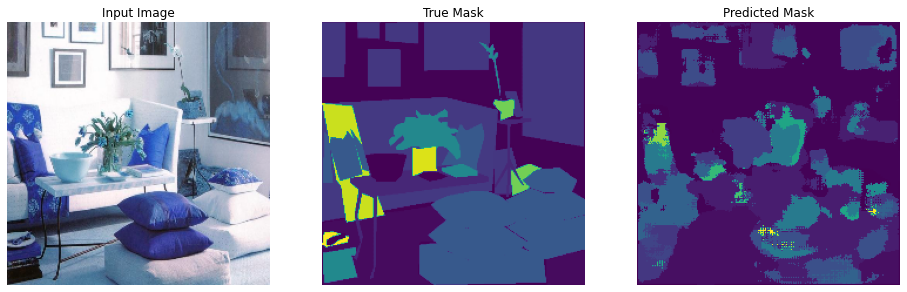

In [ ]:
for image, mask in test_dataset.take(1):
    sample_image, sample_mask = image, mask

show_predictions()

In [ ]:
test_steps = len(test_x)//batch
if len(test_x) % batch != 0: 
    test_steps += 1

result = model.evaluate(test_dataset, steps=test_steps)
dict(zip(model.metrics_names, result))

50/50 [==============================] - 3s 56ms/step - loss: 0.4805 - dice_coef: 0.5195 - accuracy: 0.4802


{'accuracy': 0.4801941215991974,
 'dice_coef': 0.519536554813385,
 'loss': 0.480463445186615}